In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import itertools

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
def read_data_and_create_df(data_file_path):
    df = pd.read_csv(data_file_path)
    return df

def convert_df_for_SARIMAX(orig_df, acc_num):
    df_one_acc_rev = orig_df[orig_df["ACCOUNT_NUMBER"].isin(acc_num)]
    df_one_acc_rev.drop(["CODE_COMBINATION_ID", "ACCOUNT_NUMBER"], axis=1, inplace=True)
    df_one_acc_rev["LAST_UPDATE_DATE"] = pd.to_datetime(df_one_acc_rev["LAST_UPDATE_DATE"])
    df_one_acc_rev.sort_values("LAST_UPDATE_DATE")
    
    df_one_acc_rev_agg = df_one_acc_rev.groupby("LAST_UPDATE_DATE").agg({"ACCOUNTED_BAL_USD": ["sum"]})
    df_one_acc_rev_agg.columns = ["SUM_OF_ACCOUNTED_BAL_USD"]

    df_one_acc_rev_agg = df_one_acc_rev_agg.reset_index()

    df_one_acc_rev_agg["LAST_UPDATE_DATE"] = pd.to_datetime(df_one_acc_rev_agg["LAST_UPDATE_DATE"])

    df_one_acc_rev_agg = df_one_acc_rev_agg.set_index("LAST_UPDATE_DATE")
    return df_one_acc_rev_agg

def create_SARIMAX_target(sarimax_df):
    return sarimax_df["SUM_OF_ACCOUNTED_BAL_USD"].resample("MS").mean()

## Before Modularization

In [5]:
df = pd.read_csv("final_data.csv")

In [6]:
df.head()

,LAST_UPDATE_DATE,CODE_COMBINATION_ID,ACCOUNT_NUMBER,ACCOUNTED_BAL_USD
0,2015-10-05,11475261,4004,176334.30
1,2015-10-04,11475294,4603,-76954.09
2,2015-10-05,11475308,4654,-899.95
3,2015-09-28,11475308,4654,-405.06
4,2015-09-14,11475308,4654,1345.64


In [7]:
def draw_trend_graph(acc_number):
    df_acc = df[df["ACCOUNT_NUMBER"] == acc_number]
    print(f"The total record is {df_acc.shape}")
    
    df_acc_agg = df_acc.groupby("LAST_UPDATE_DATE").agg({"ACCOUNTED_BAL_USD": ["sum"]})
#     df_4004_agg.head()
    df_acc_agg.columns = ["SUM_OF_ACCOUNTED_BAL_USD"]
    df_acc_agg = df_acc_agg.reset_index()
#     df_acc_agg.head()
    plt.plot(df_acc_agg['LAST_UPDATE_DATE'], df_acc_agg['SUM_OF_ACCOUNTED_BAL_USD'])
    plt.title("Account trends")
    plt.ylabel("Revenue ($)")
    plt.show()

In [8]:
# draw_trend_graph(5211)
acc_num = [4603]

df_one_acc_rev = df[df["ACCOUNT_NUMBER"].isin(acc_num)]

print(df_one_acc_rev.columns)
df_one_acc_rev.drop(["CODE_COMBINATION_ID", "ACCOUNT_NUMBER"], axis=1, inplace=True)
df_one_acc_rev["LAST_UPDATE_DATE"] = pd.to_datetime(df_one_acc_rev["LAST_UPDATE_DATE"])
df_one_acc_rev.sort_values("LAST_UPDATE_DATE")

df_one_acc_rev.isnull().sum()
df_one_acc_rev.head()

Index(['LAST_UPDATE_DATE', 'CODE_COMBINATION_ID', 'ACCOUNT_NUMBER',
       'ACCOUNTED_BAL_USD'],
      dtype='object')


,LAST_UPDATE_DATE,ACCOUNTED_BAL_USD
1,2015-10-04,-76954.09
20,2015-10-04,-54752.15
21,2015-10-04,-20960.11
22,2015-10-04,-9675.40
40,2015-10-04,-19941.53


In [9]:
df_one_acc_rev_agg = df_one_acc_rev.groupby("LAST_UPDATE_DATE").agg({"ACCOUNTED_BAL_USD": ["sum"]})

In [10]:
df_one_acc_rev_agg.columns = ["SUM_OF_ACCOUNTED_BAL_USD"]

df_one_acc_rev_agg = df_one_acc_rev_agg.reset_index()

df_one_acc_rev_agg["LAST_UPDATE_DATE"] = pd.to_datetime(df_one_acc_rev_agg["LAST_UPDATE_DATE"])

df_one_acc_rev_agg = df_one_acc_rev_agg.set_index("LAST_UPDATE_DATE")
df_one_acc_rev_agg.index

DatetimeIndex(['2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13',
               '2015-02-16', '2015-02-18', '2015-02-20', '2015-02-23',
               '2015-02-24', '2015-02-25',
               ...
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07'],
              dtype='datetime64[ns]', name='LAST_UPDATE_DATE', length=1048, freq=None)

In [11]:
df_one_acc_rev_agg.head()

,SUM_OF_ACCOUNTED_BAL_USD
LAST_UPDATE_DATE,
2015-02-10,-1586142.05
2015-02-11,-217423.96
2015-02-12,-41249.02
2015-02-13,-699871.58
2015-02-16,-438145.96


In [12]:
y = df_one_acc_rev_agg["SUM_OF_ACCOUNTED_BAL_USD"].resample("MS").mean()

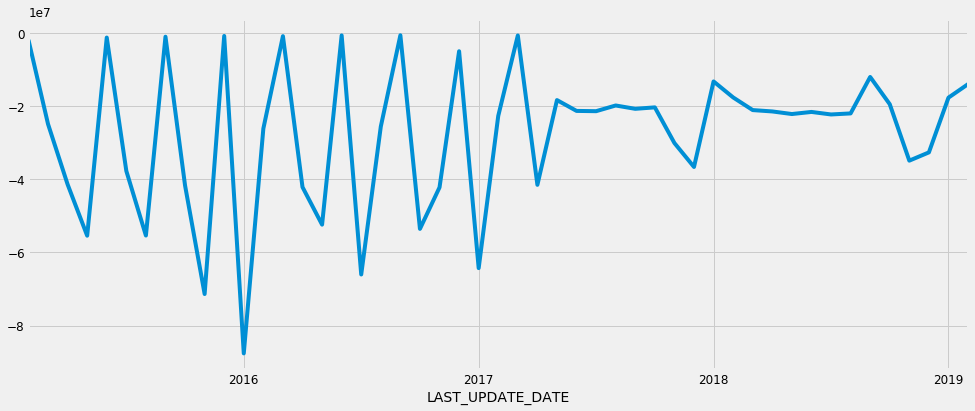

In [13]:
y.plot(figsize=(15, 6))
plt.show()

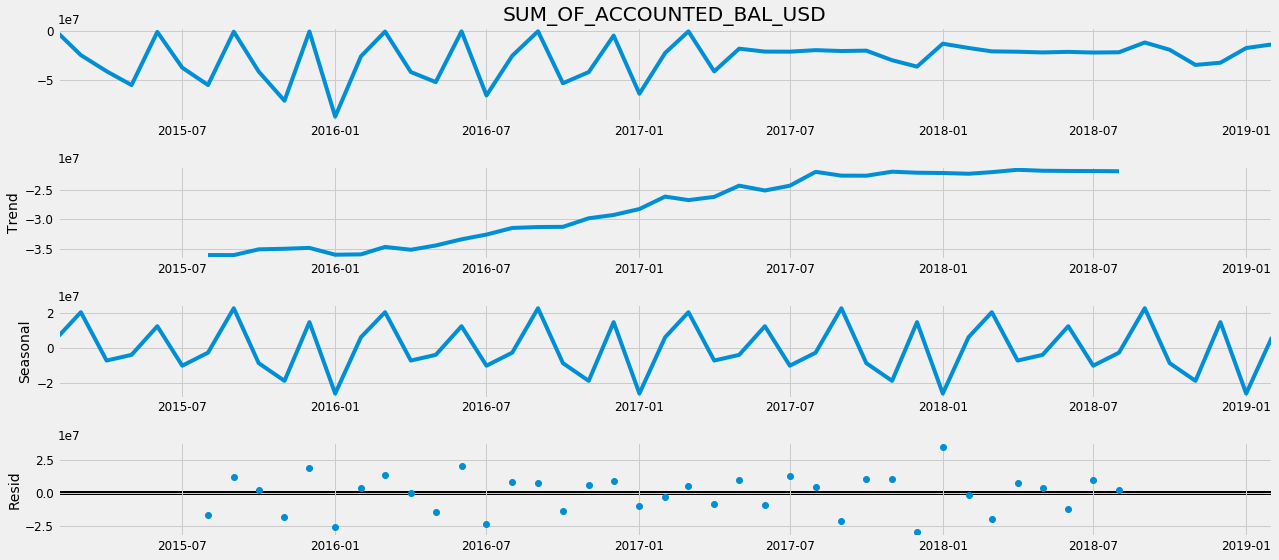

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [15]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
min_aic = 0
p_ = None
sp_ = None
cnt = 0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, paramer=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                           )
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if cnt == 0:
                min_aic = results.aic
                cnt += 1
            else:
                if results.aic < min_aic:
                    min_aic = results.aic
                    p_ = param
                    sp_ = seasonal_pdq
        except:
            continue
            
print(f"The min aic is {min_aic} with param {p_} and {sp_}")

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1789.9857694685252
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1321.1389056123662
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1307.425847465379
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2540.9906774404744
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1317.4639598028077
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1319.3659507602565
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:877.2502129564313
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:863.7546968449876
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1789.9857694685252
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1321.1389056123662
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1307.425847465379
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2540.9906774404744
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1317.4639598028077
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1319.3659507602565
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:877.2502129564313
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:863.7546968449876
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1789.9857694685252
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1321.138905612366

In [19]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1651      1.833      0.090      0.928      -3.427       3.757
ma.L1         -0.7739      1.608     -0.481      0.630      -3.925       2.377
ar.S.L12      -0.0275      0.965     -0.029      0.977      -1.919       1.864
ma.S.L12      -1.0140      0.287     -3.538      0.000      -1.576      -0.452
sigma2      4.799e+14   9.98e-16   4.81e+29      0.000     4.8e+14     4.8e+14


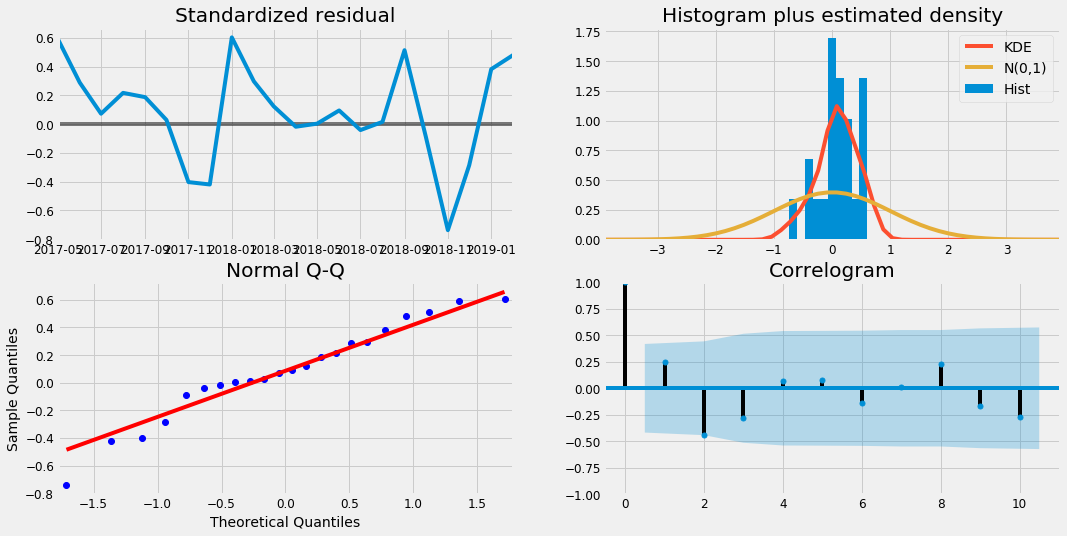

In [20]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

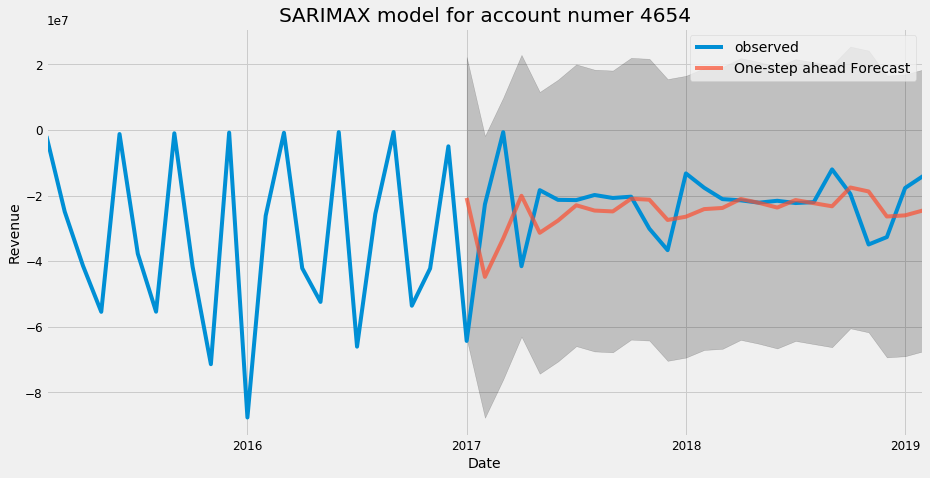

In [21]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
ax.set_title("SARIMAX model for account numer 4654")
plt.legend()
plt.show()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 198271016539033.97


In [23]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 14080874.14


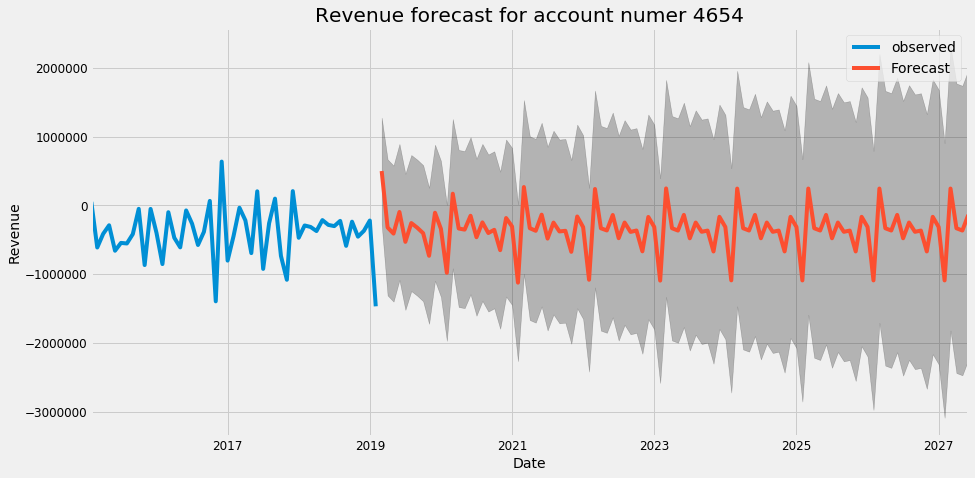

In [19]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
ax.set_title("Revenue forecast for account numer 4654")
plt.legend()
plt.show()

In [29]:
from fbprophet import Prophet

dd = df_one_acc_rev_agg.reset_index()
dd = dd.rename(columns={'LAST_UPDATE_DATE': 'ds', 'SUM_OF_ACCOUNTED_BAL_USD': 'y'})
rev_model = Prophet(interval_width=0.95)
rev_model.fit(dd)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
rev_forecast = rev_model.make_future_dataframe(periods=36, freq='MS')
rev_forecast = rev_model.predict(rev_forecast)

<Figure size 1296x432 with 0 Axes>

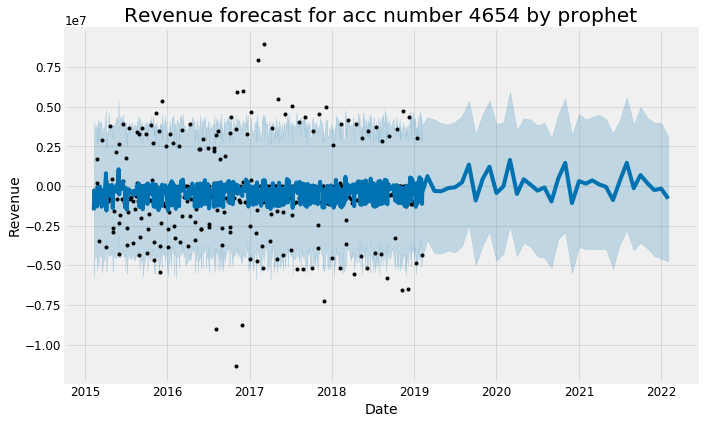

In [31]:
plt.figure(figsize=(18, 6))
rev_model.plot(rev_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.title('Revenue forecast for acc number 4654 by prophet');

## Bellow are the old experiements

In [74]:
df_agg = df.groupby("LAST_UPDATE_DATE").agg({"ACCOUNTED_BAL_USD": ["sum"]})

In [75]:
df_agg.columns = ["SUM_OF_ACCOUNTED_BAL_USD"]

df_agg = df_agg.reset_index()

df_agg["LAST_UPDATE_DATE"] = pd.to_datetime(df_agg["LAST_UPDATE_DATE"])

df_agg = df_agg.set_index("LAST_UPDATE_DATE")
df_agg.index

DatetimeIndex(['2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13',
               '2015-02-14', '2015-02-15', '2015-02-16', '2015-02-17',
               '2015-02-18', '2015-02-19',
               ...
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07'],
              dtype='datetime64[ns]', name='LAST_UPDATE_DATE', length=1322, freq=None)

In [76]:
df_agg.head()

,SUM_OF_ACCOUNTED_BAL_USD
LAST_UPDATE_DATE,
2015-02-10,8991987.02
2015-02-11,2142995.45
2015-02-12,229454.51
2015-02-13,4297140.71
2015-02-14,4634270.64


In [77]:
df_agg.shape

(1322, 1)

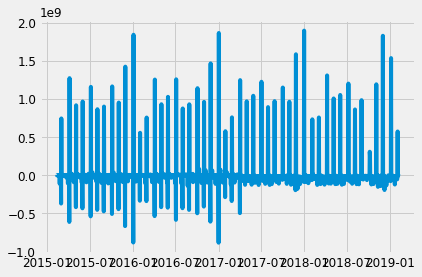

In [78]:
plt.plot(df_agg.index, df_agg["SUM_OF_ACCOUNTED_BAL_USD"])
plt.show()

In [79]:
y = df_agg["SUM_OF_ACCOUNTED_BAL_USD"].resample("MS").mean()

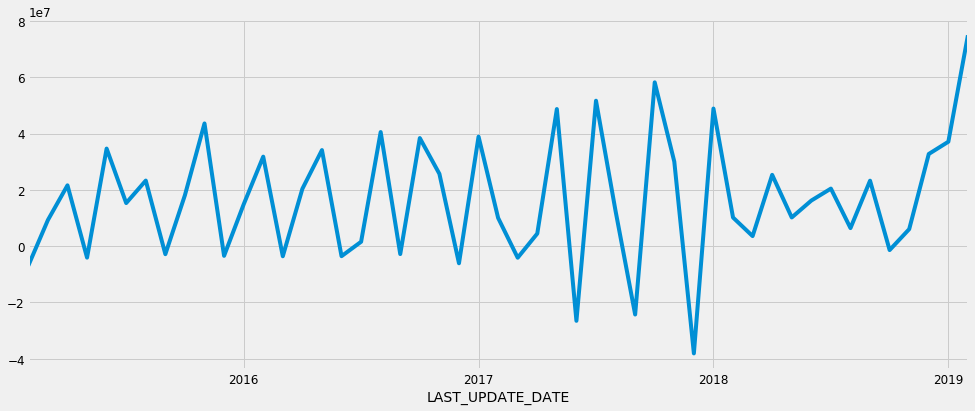

In [80]:
y.plot(figsize=(15, 6))
plt.show()

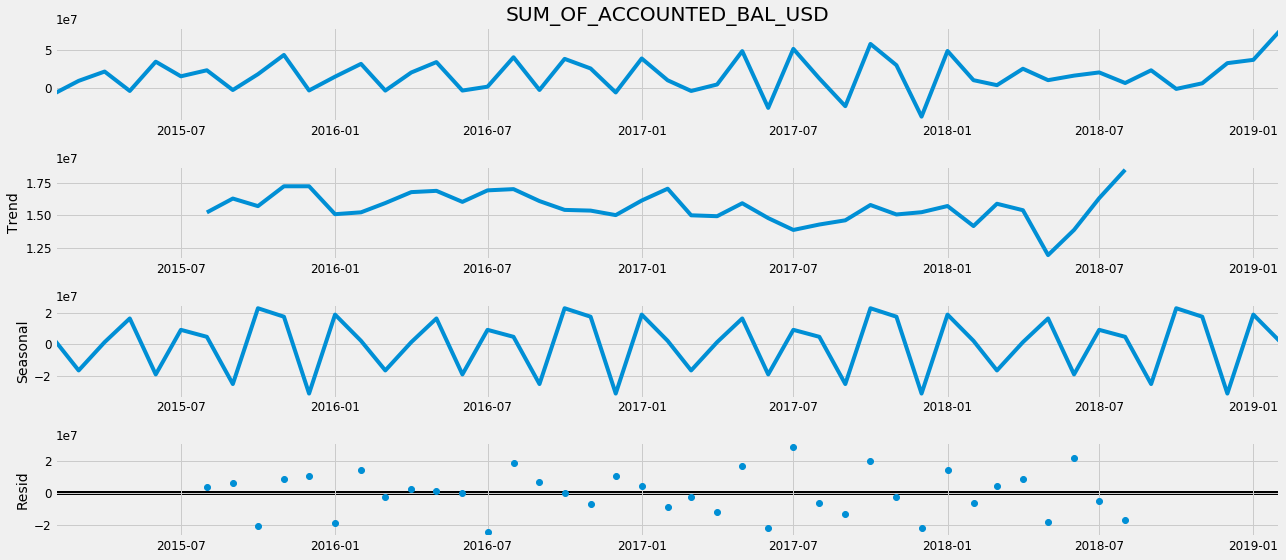

In [84]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [86]:
rev_acc = [4004, 4603, 4654]

In [87]:
df_rev = df[df["ACCOUNT_NUMBER"].isin(rev_acc)]

In [90]:
df_rev.head()

,LAST_UPDATE_DATE,CODE_COMBINATION_ID,ACCOUNT_NUMBER,ACCOUNTED_BAL_USD
0,2015-10-05,11475261,4004,176334.30
1,2015-10-04,11475294,4603,-76954.09
2,2015-10-05,11475308,4654,-899.95
3,2015-09-28,11475308,4654,-405.06
4,2015-09-14,11475308,4654,1345.64


In [91]:
!pip install fastai

     |################################| 237 kB 4.5 MB/s eta 0:00:01
     |################################| 753.4 MB 13 kB/s s eta 0:00:01     |###############                 | 357.0 MB 44.7 MB/s eta 0:00:09     |#################               | 412.5 MB 32.7 MB/s eta 0:00:11     |#################               | 422.3 MB 32.7 MB/s eta 0:00:11     |##################              | 434.2 MB 43.7 MB/s eta 0:00:08     |##################              | 442.9 MB 43.7 MB/s eta 0:00:08     |#######################         | 556.3 MB 20.3 MB/s eta 0:00:10     |#######################         | 562.2 MB 20.3 MB/s eta 0:00:10     |########################        | 574.6 MB 42.7 MB/s eta 0:00:05     |#########################       | 605.4 MB 42.7 MB/s eta 0:00:04     |#########################       | 609.3 MB 34.1 MB/s eta 0:00:05     |############################    | 673.0 MB 47.2 MB/s eta 0:00:02     |############################    | 678.7 MB 47.2 MB/s eta 0:00:02     |################

  ERROR: Command errored out with exit status 1:
   command: /home/ec2-user/venv/bin/python3 /home/ec2-user/venv/local/lib/python3.6/site-packages/pip/_vendor/pep517/_in_process.py build_wheel /tmp/tmpc852nwfs
       cwd: /tmp/pip-install-ock1cvue/bottleneck
  Complete output (122 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.6
  creating build/lib.linux-x86_64-3.6/bottleneck
  copying bottleneck/__init__.py -> build/lib.linux-x86_64-3.6/bottleneck
  copying bottleneck/_pytesttester.py -> build/lib.linux-x86_64-3.6/bottleneck
  copying bottleneck/_version.py -> build/lib.linux-x86_64-3.6/bottleneck
  creating build/lib.linux-x86_64-3.6/bottleneck/tests
  copying bottleneck/tests/list_input_test.py -> build/lib.linux-x86_64-3.6/bottleneck/tests
  copying bottleneck/tests/memory_test.py -> build/lib.linux-x86_64-3.6/bottleneck/tests
  copying bottleneck/tests/nonreduce_axis_test.py -> build/lib.linux-x86_64-3.6/bottl

In [92]:
!python --version

Python 3.6.8


In [93]:
!pip install http://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl

     |################################| 69.4 MB 50.1 MB/s eta 0:00:01   |                                | 2.0 MB 5.7 MB/s eta 0:00:12
You should consider upgrading via the '/home/ec2-user/venv/bin/python3 -m pip install --upgrade pip' command.


In [99]:
!pip install --no-use-pep517 fastai

  Using cached fastai-1.0.60-py3-none-any.whl (237 kB)
  Using cached packaging-20.1-py2.py3-none-any.whl (36 kB)
  Using cached torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl (4.0 MB)
  Using cached dataclasses-0.7-py3-none-any.whl (18 kB)
  Using cached torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl (753.4 MB)
  Using cached Bottleneck-1.3.1.tar.gz (88 kB)
  ERROR: Command errored out with exit status 1:
   command: /home/ec2-user/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-5hybnzwy/bottleneck/setup.py'"'"'; __file__='"'"'/tmp/pip-install-5hybnzwy/bottleneck/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-731qeo8o
       cwd: /tmp/pip-install-5hybnzwy/bottleneck/
  Complete output (127 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating b

Failed to build bottleneck
    Running setup.py install for bottleneck ... error
    ERROR: Command errored out with exit status 1:
     command: /home/ec2-user/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-5hybnzwy/bottleneck/setup.py'"'"'; __file__='"'"'/tmp/pip-install-5hybnzwy/bottleneck/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-whtytimv/install-record.txt --single-version-externally-managed --compile --install-headers /home/ec2-user/venv/include/site/python3.6/bottleneck
         cwd: /tmp/pip-install-5hybnzwy/bottleneck/
    Complete output (127 lines):
    running install
    running build
    running build_py
    creating build
    creating build/lib.linux-x86_64-3.6
    creating build/lib.linux-x86_64-3.6/bottleneck
    copying bottleneck/__init__.py -> build/lib.lin